# Short Report: Approximating the Runge Function with a Neural Network

**Method**

I implemented a feedforward neural network using PyTorch to approximate the Runge function

f(x) = 1 / (1 + 25 x^2)

over x in [-1, 1]. The network architecture:

- Input: 1 neuron
- Hidden 1: 20 neurons, tanh
- Hidden 2: 50 neurons, sigmoid
- Output: 1 neuron, linear

Training data: 1000 uniformly spaced points in [-1,1]. Test data: 500 uniform points.

Loss: MSE. Optimizer: Adam (lr=0.01). Epochs: 1000.

This notebook provides training, evaluation, visualizations, and model saving/loading.

In [96]:
%pip install torch

import time
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Matplotlib default figure size
plt.rcParams['figure.figsize'] = (8, 5)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [97]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [98]:
# Define Runge function and generate data

def runge(x):
    return 1.0 / (1.0 + 25.0 * x**2)

# Training data: 1000 uniform points
n_train = 1000
x_train = np.linspace(-1, 1, n_train).astype(np.float32).reshape(-1, 1)
y_train = runge(x_train).astype(np.float32).reshape(-1, 1)

# Test data: 500 uniform points
n_test = 500
x_test = np.linspace(-1, 1, n_test).astype(np.float32).reshape(-1, 1)
y_test = runge(x_test).astype(np.float32).reshape(-1, 1)

print('Train:', x_train.shape, y_train.shape)
print('Test: ', x_test.shape, y_test.shape)

Train: (1000, 1) (1000, 1)
Test:  (500, 1) (500, 1)


In [99]:
# Create training and test datasets (PyTorch tensors & DataLoader)

train_tensor_x = torch.from_numpy(x_train)
train_tensor_y = torch.from_numpy(y_train)

test_tensor_x = torch.from_numpy(x_test)
test_tensor_y = torch.from_numpy(y_test)

batch_size = 128
train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

eval_loader = DataLoader(TensorDataset(test_tensor_x, test_tensor_y), batch_size=len(test_tensor_x), shuffle=False)

In [100]:
# Define feedforward neural network (nn.Module)

class RungeNet(nn.Module):
    def __init__(self):
        super(RungeNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 50),
            nn.Sigmoid(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate and move to device
model = RungeNet().to(device)
print(model)

RungeNet(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [101]:
# Initialize model, loss, optimizer, and hyperparameters

lr = 0.01
epochs = 1000

# Xavier initialization for linear layers
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

print(f'Learning rate: {lr}, epochs: {epochs}')

Learning rate: 0.01, epochs: 1000


In [102]:
# Training loop with loss logging and optional checkpointing

train_losses = []
start_time = time.time()

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / n_train
    train_losses.append(epoch_loss)

    if epoch % 100 == 0 or epoch == 1:
        elapsed = time.time() - start_time
        print(f'Epoch {epoch:4d}/{epochs} — loss: {epoch_loss:.6f} — elapsed: {elapsed:.1f}s')

# Optional: save final checkpoint
# torch.save(model.state_dict(), 'runge_final_checkpoint.pth')

print('Training completed in %.1f seconds' % (time.time() - start_time))

Epoch    1/1000 — loss: 0.211241 — elapsed: 0.0s
Epoch  100/1000 — loss: 0.000008 — elapsed: 1.5s
Epoch  200/1000 — loss: 0.000003 — elapsed: 3.0s
Epoch  300/1000 — loss: 0.000004 — elapsed: 4.5s
Epoch  400/1000 — loss: 0.000219 — elapsed: 6.0s
Epoch  500/1000 — loss: 0.000013 — elapsed: 7.5s
Epoch  600/1000 — loss: 0.000263 — elapsed: 8.9s
Epoch  700/1000 — loss: 0.000545 — elapsed: 10.4s
Epoch  800/1000 — loss: 0.000022 — elapsed: 12.0s
Epoch  900/1000 — loss: 0.000025 — elapsed: 13.7s
Epoch 1000/1000 — loss: 0.000000 — elapsed: 15.2s
Training completed in 15.2 seconds


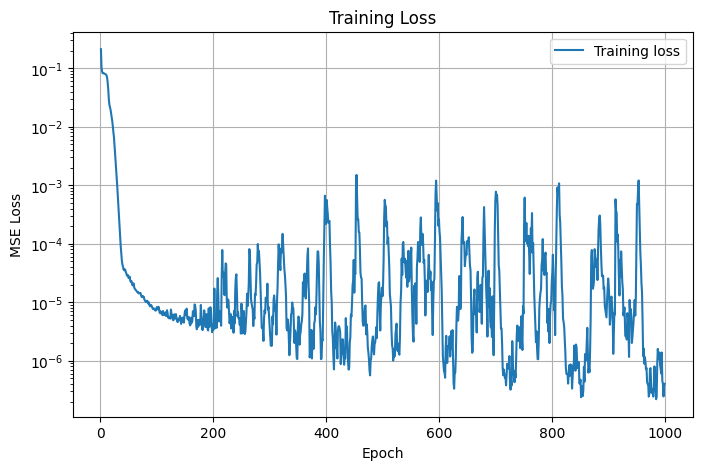

In [103]:
# Plot training loss curve
plt.figure()
plt.plot(np.arange(1, epochs+1), train_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
# Evaluate on test set (MSE)
model.eval()
with torch.no_grad():
    tx = test_tensor_x.to(device)
    ty = test_tensor_y.to(device)
    preds = model(tx)
    test_mse = criterion(preds, ty).item()

print(f'Test MSE: {test_mse:.8f}')

Test MSE: 0.00000031


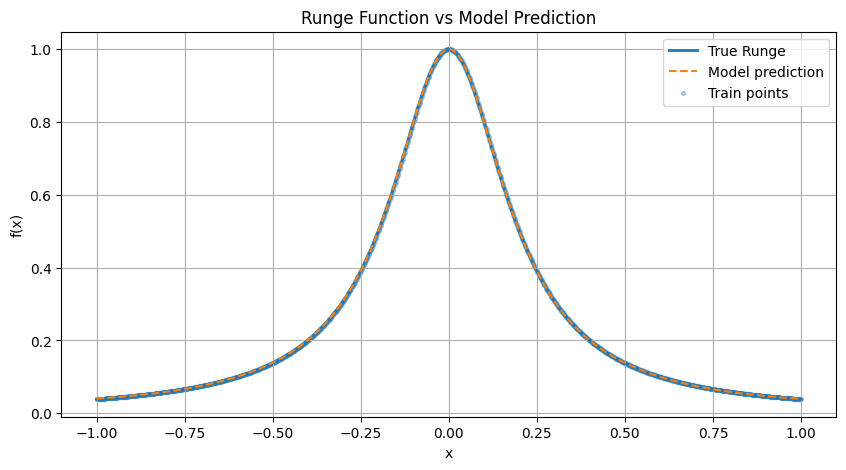

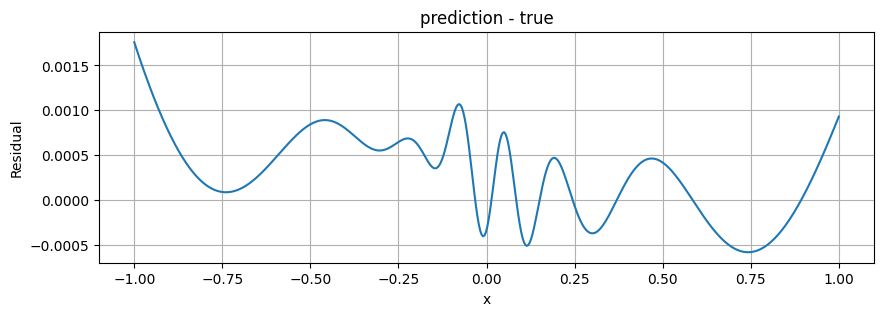

In [105]:
# Plot predictions vs ground truth
x_dense = np.linspace(-1, 1, 500, dtype=np.float32).reshape(-1, 1)
x_dense_t = torch.from_numpy(x_dense).to(device)

model.eval()
with torch.no_grad():
    y_pred_dense = model(x_dense_t).cpu().numpy()

y_true_dense = runge(x_dense)

plt.figure(figsize=(10, 5))
plt.plot(x_dense, y_true_dense, label='True Runge', linewidth=2)
plt.plot(x_dense, y_pred_dense, label='Model prediction', linestyle='--')
plt.scatter(x_train, y_train, s=8, alpha=0.3, label='Train points')
plt.legend()
plt.title('Runge Function vs Model Prediction')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

# Residuals
residuals = y_pred_dense.flatten() - y_true_dense.flatten()
plt.figure(figsize=(10, 3))
plt.plot(x_dense, residuals)
plt.title('prediction - true')
plt.xlabel('x')
plt.ylabel('Residual')
plt.grid(True)
plt.show()